<a href="https://colab.research.google.com/github/ChristianMocha/PrediccionVideoJuegos/blob/master/PrediccionVideoJuegos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
from pandas import Series
from math import ceil

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_csv('../content/Video_Games_Sales_as_at_22_Dec_2016.csv', encoding="utf-8")
dfa = df
dfa = dfa.copy()
df[:5]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


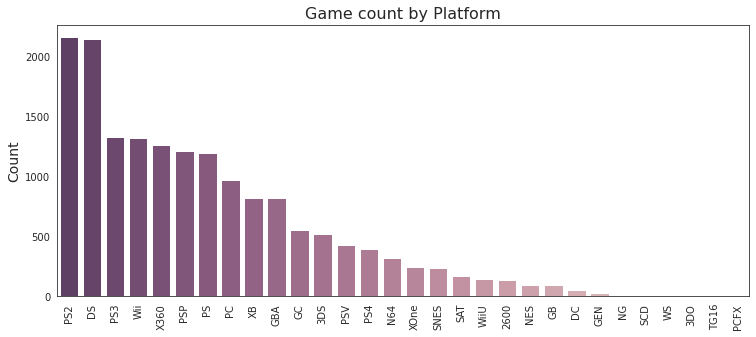

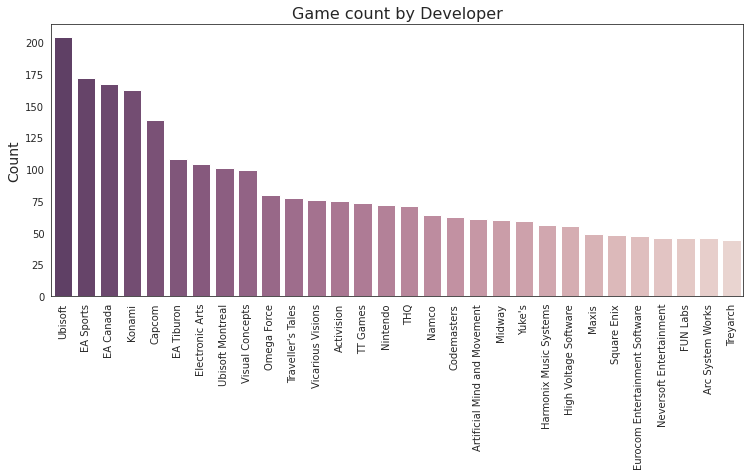

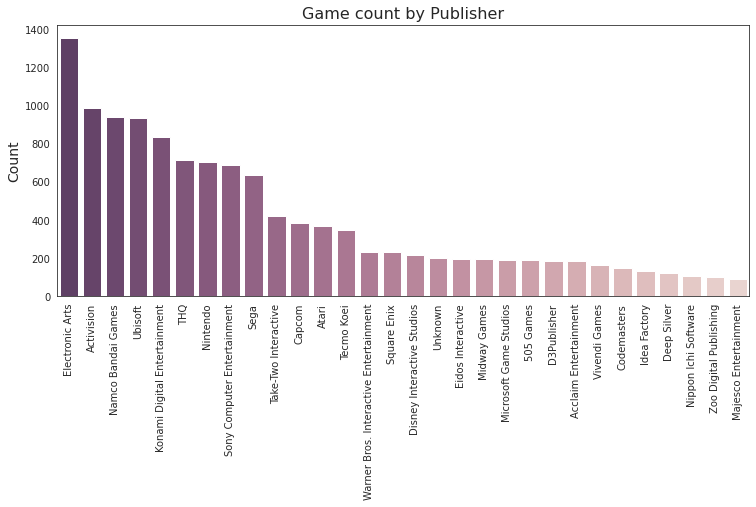

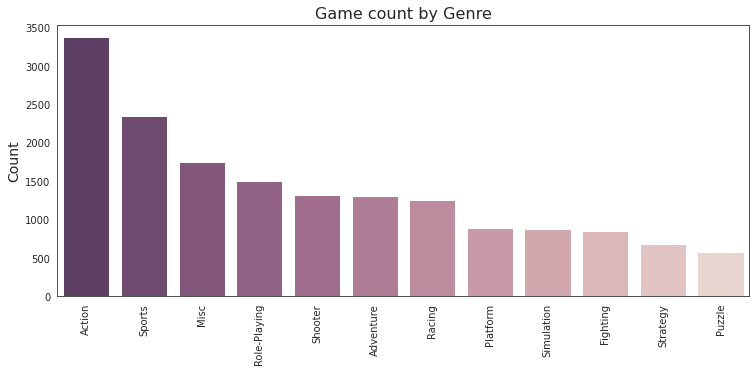

In [5]:
cols = ['Platform', 'Developer', 'Publisher', 'Genre']

for col in cols:
    chart = df[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()
    sns.set_style("white")
    plt.figure(figsize=(12.4, 5))
    plt.xticks(rotation=90)
    sns.barplot(x=col, y='Name', data=chart[:30], palette=sns.cubehelix_palette((12 if col == 'Genre' else 30), dark=0.3, light=.85, reverse=True)).set_title(('Game count by '+col), fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('')

In [6]:
def score_group(score):
    if score >= 90:
        return '90-100'
    elif score >= 80:
        return '80-89'
    elif score >= 70:
        return '70-79'
    elif score >= 60:
        return '60-69'
    elif score >= 50:
        return '50-59'
    else:
        return '0-49'

In [8]:
dfh = df.dropna(subset=['Critic_Score']).reset_index(drop=True)
dfh['Score_Group'] = dfh['Critic_Score'].apply(lambda x: score_group(x))

In [9]:
def in_top(x):
    if x in pack:
        return x
    else:
        pass
def width(x):
    if x == 'Platform':
        return 14.4
    elif x == 'Developer':
        return 13.2
    elif x == 'Publisher':
        return 11.3
    elif x == 'Genre':
        return 13.6

def height(x):
    if x == 'Genre':
        return 8
    else:
        return 9

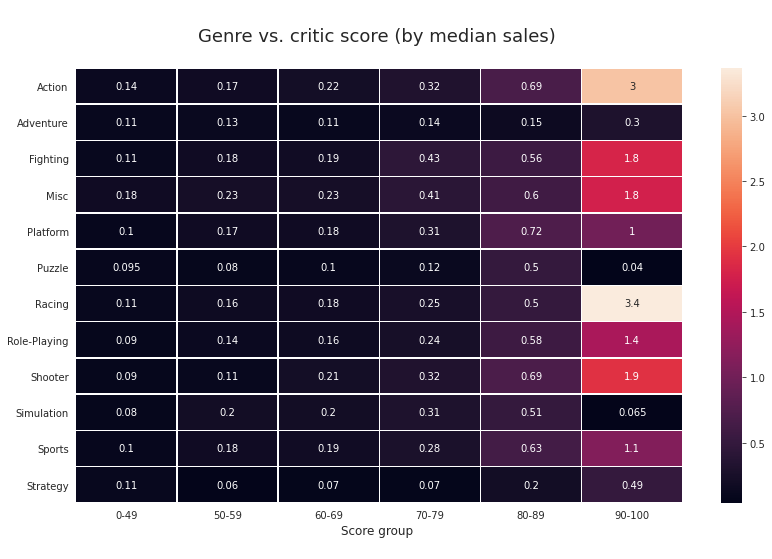

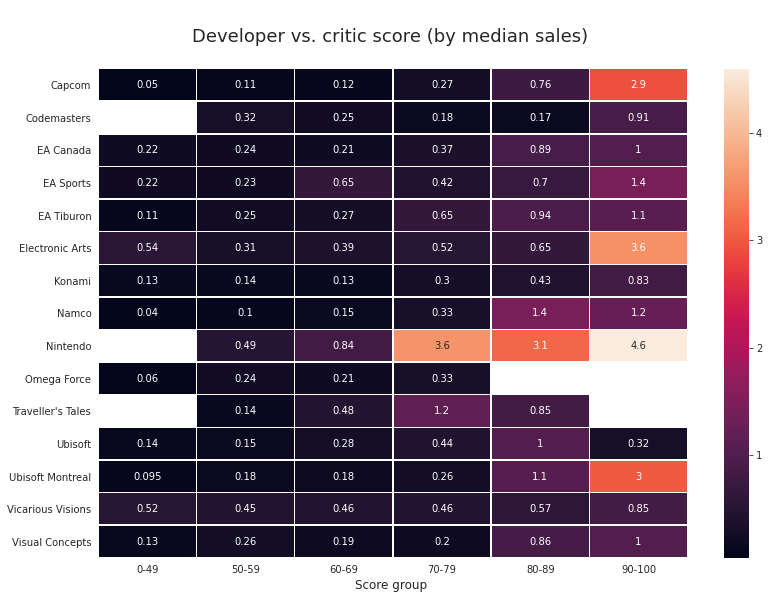

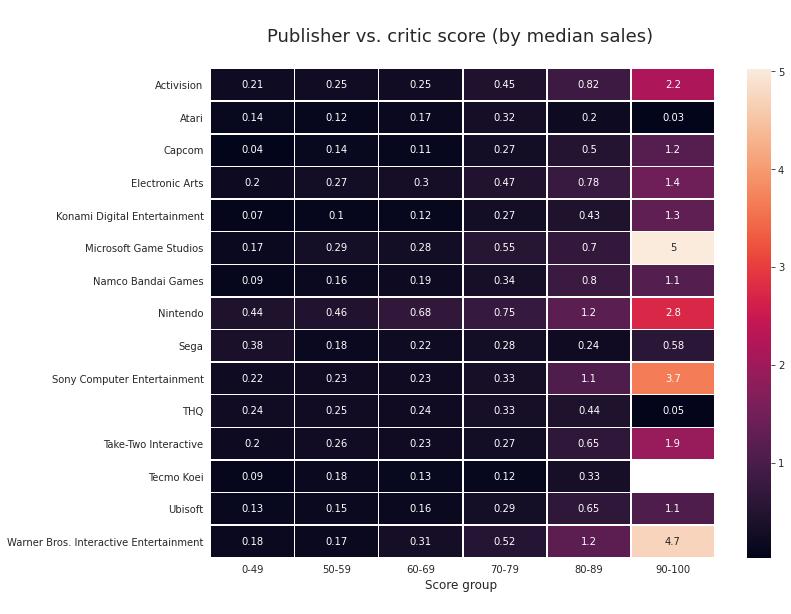

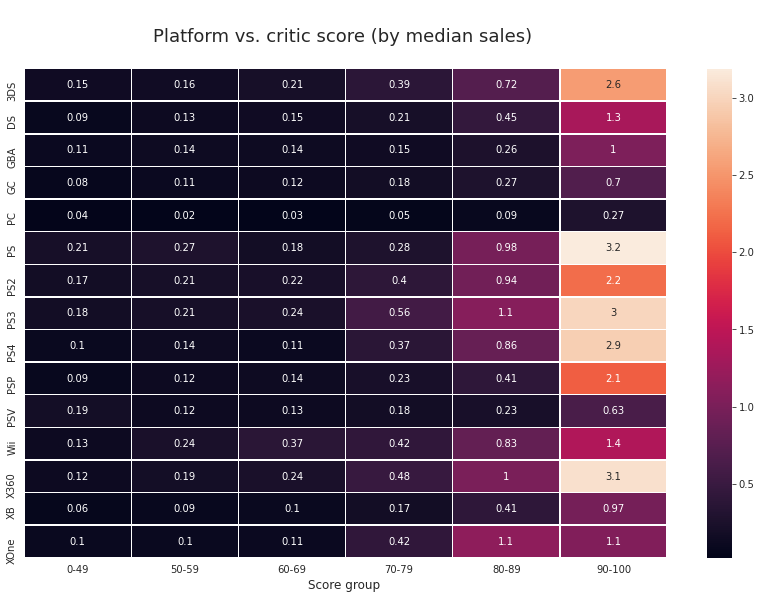

In [10]:
cols = ['Genre', 'Developer', 'Publisher', 'Platform']
for col in cols:
    pack = []
    top = dfh[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()[:15]
    for x in top[col]:
        pack.append(x)
    dfh[col] = dfh[col].apply(lambda x: in_top(x))
    dfh_platform = dfh[[col, 'Score_Group', 'Global_Sales']].groupby([col, 'Score_Group']).median().reset_index().pivot(col, "Score_Group", "Global_Sales")
    plt.figure(figsize=(width(col), height(col)))
    sns.heatmap(dfh_platform, annot=True, fmt=".2g", linewidths=.5).set_title((' \n'+col+' vs. critic score (by median sales) \n'), fontsize=18)
    plt.ylabel('', fontsize=14)
    plt.xlabel('Score group \n', fontsize=12)
    pack = []

In [11]:
cols = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
for col in cols:
    uniques = df[col].value_counts().keys()
    uniques_dict = {}
    ct = 0
    for i in uniques:
        uniques_dict[i] = ct
        ct += 1

    for k, v in uniques_dict.items():
        df.loc[df[col] == k, col] = v

In [12]:
df1 = df[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
df1 = df1.dropna().reset_index(drop=True)
df1 = df1.astype('float64')

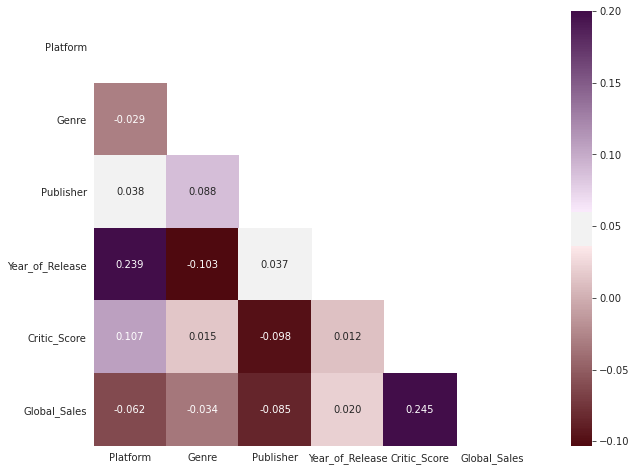

In [13]:
mask = np.zeros_like(df1.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(730, 300, sep=20, as_cmap=True, s=85, l=15, n=20) # note: 680, 350/470
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1, figsize=(15,8))
    ax = sns.heatmap(df1.corr(), mask=mask, vmax=0.2, square=True, annot=True, fmt=".3f", cmap=cmap)

[(0.0, 17.5)]

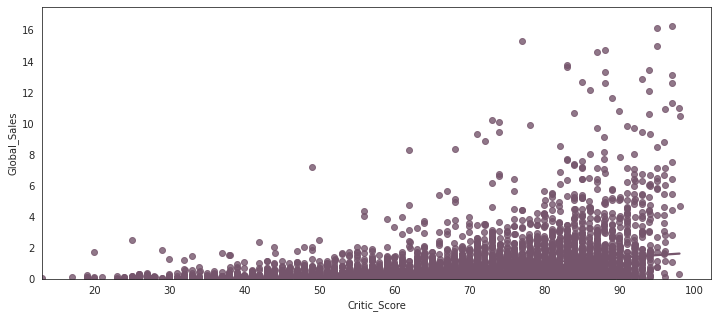

In [14]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df1, ci=None, color="#75556c", x_jitter=.02).set(ylim=(0, 17.5))

[(0.0, 4.0), (50.0, 95.0)]

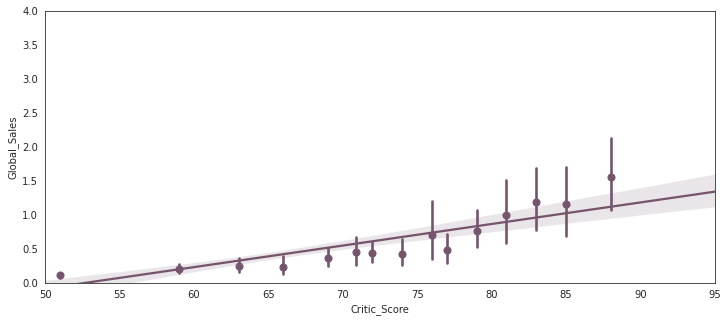

In [15]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df1.loc[df1.Year_of_Release >= 2014],
            truncate=True, x_bins=15, color="#75556c").set(ylim=(0, 4), xlim=(50, 95))

In [16]:
dfb = dfa[['Name','Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
dfb = dfb.dropna().reset_index(drop=True)
df2 = dfb[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
df2['Hit'] = df2['Global_Sales']
df2.drop('Global_Sales', axis=1, inplace=True)

In [17]:
def hit(sales):
    if sales >= 1:
        return 1
    else:
        return 0

df2['Hit'] = df2['Hit'].apply(lambda x: hit(x))

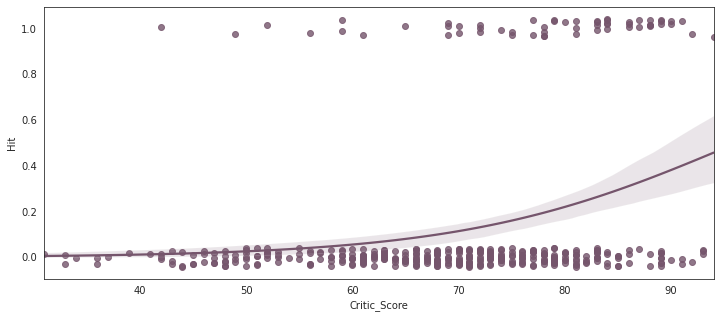

In [18]:
# Logistic regression plot with sample of the data
n = ceil(0.05 * len(df2['Hit']))
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Hit", data=df2.sample(n=n),
            logistic=True, n_boot=500, y_jitter=.04, color="#75556c")

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

In [20]:
df2[:5]

,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Hit
0,Wii,Sports,Nintendo,2006.0,76.0,1
1,Wii,Racing,Nintendo,2008.0,82.0,1
2,Wii,Sports,Nintendo,2009.0,80.0,1
3,DS,Platform,Nintendo,2006.0,89.0,1
4,Wii,Misc,Nintendo,2006.0,58.0,1


In [21]:
from pandas import get_dummies
df_copy = pd.get_dummies(df2)

In [22]:
df_copy[:5]

,Year_of_Release,Critic_Score,Hit,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Publisher_10TACLE Studios,Publisher_1C Company,Publisher_2D Boy,Publisher_3DO,Publisher_505 Games,Publisher_5pb,Publisher_AQ Interactive,Publisher_ASCII Entertainment,...,Publisher_Telegames,Publisher_Telltale Games,Publisher_Tetris Online,Publisher_The Adventure Company,Publisher_Titus,Publisher_Tomy Corporation,Publisher_Touchstone,Publisher_Trion Worlds,Publisher_Tripwire Interactive,Publisher_Tru Blu Entertainment,Publisher_UFO Interactive,Publisher_Ubisoft,Publisher_Ubisoft Annecy,Publisher_Universal Interactive,Publisher_Unknown,Publisher_Valcon Games,Publisher_Valve,Publisher_Valve Software,Publisher_Vatical Entertainment,Publisher_Victor Interactive,Publisher_Vir2L Studios,Publisher_Virgin Interactive,Publisher_Visco,Publisher_Vivendi Games,Publisher_Wanadoo,Publisher_Wargaming.net,Publisher_Warner Bros. Interactive Entertainment,Publisher_White Park Bay Software,Publisher_XS Games,Publisher_Xicat Interactive,Publisher_Xplosiv,Publisher_Xseed Games,Publisher_Yacht Club Games,Publisher_Yuke's,Publisher_Zoo Digital Publishing,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_id Software,Publisher_inXile Entertainment
0,2006.0,76.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2008.0,82.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2009.0,80.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2006.0,89.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2006.0,58.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
df3 = df_copy
y = df3['Hit'].values
df3 = df3.drop(['Hit'],axis=1)
X = df3.values

In [24]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50, random_state=2)

In [31]:
from time import time
start_time = time()
radm = RandomForestClassifier(random_state=2).fit(Xtrain, ytrain)

y_val_1 = radm.predict(Xtest)
val = print("Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                   == ytest)/len(ytest))

from sklearn.metrics import zero_one_loss
error_rate_svm = zero_one_loss(ytest,y_val_1)
error_rate_svm=str(round(error_rate_svm, 4))
print("Error rate (%): ",error_rate_svm)
elapsed_time = time() - start_time
print("Tiempo de ejecución (s): ", elapsed_time)

Validation accuracy:  0.8271109997494362
Error rate (%):  0.1376
Tiempo de ejecución (s):  1.1806561946868896


In [32]:
from time import time
start_time1 = time()
log_reg = LogisticRegression().fit(Xtrain, ytrain)

y_val_2 = log_reg.predict(Xtest)

val1 = print("Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values
                                   == ytest)/len(ytest))

from sklearn.metrics import zero_one_loss
error_rate_svm = zero_one_loss(ytest,y_val_2)
error_rate_svm=str(round(error_rate_svm, 4))
print("Error rate (%): ",error_rate_svm)
elapsed_time1 = time() - start_time1
print("Tiempo de ejecución (s): ",elapsed_time1)

Validation accuracy:  0.8271109997494362
Error rate (%):  0.1351
Tiempo de ejecución (s):  0.29047584533691406


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [34]:
from sklearn.svm import SVC
classifier = SVC(gamma="auto", kernel='poly', C=0.1, random_state = 0, verbose=True)
from time import time
start_time2 = time()
classifier.fit(Xtrain,ytrain)

#Predicciones del conjunto de Test

y_pred = classifier.predict(Xtest)
model_acc = classifier.score(Xtest, ytest)
test_acc_svm = accuracy_score(ytest, y_pred) #accuracy_score hace lo mismo que la función score 
acc_svm=str(round(test_acc_svm, 4))
print('\nSVM Accuracy con classifier.score: ', str(round(model_acc, 4)))
val2 = print('\nSVM Accuracy con accuracy_score: ', acc_svm)

from sklearn.metrics import zero_one_loss
error_rate_svm = zero_one_loss(ytest,y_pred)
error_rate_svm=str(round(error_rate_svm, 4))
print("Error rate (%): ",error_rate_svm)
elapsed_time2 = time() - start_time2
print("Tiempo de ejecución (s): ",elapsed_time2)

[LibSVM]
SVM Accuracy con classifier.score:  0.8629

SVM Accuracy con accuracy_score:  0.8629
Error rate (%):  0.1371
Tiempo de ejecución (s):  9.464864253997803
